<ipython-input-9-5f572687d60a>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - loss: 0.0093 - val_loss: 2.1327e-04
Epoch 2/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - loss: 1.3888e-05 - val_loss: 9.5909e-05
Epoch 3/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 50s 76ms/step - loss: 7.3314e-06 - val_loss: 2.0234e-05
Epoch 4/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 83s 78ms/step - loss: 8.3697e-06 - val_loss: 6.6234e-06
Epoch 5/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 50s 77ms/step - loss: 6.2585e-06 - val_loss: 1.1411e-05
328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Mean Absolute Error (MAE): 0.025924924439469567
R-squared (R2): 0.9973998560499395


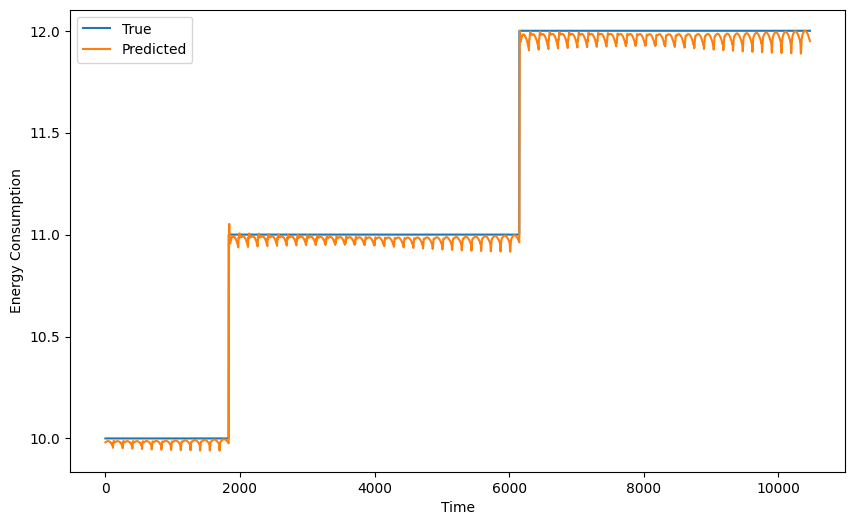

In [ ]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Load the Dataset
data = pd.read_csv('/content/powerconsumption.csv')
data['Date'] = pd.to_datetime(data['Datetime'])  # Assuming 'Date' column exists
data.set_index('Date', inplace=True)

# 2. Data Preprocessing
# Fill any missing values
data.fillna(method='ffill', inplace=True)

# Feature Engineering (extracting time-based features)
data['Month'] = data.index.month
data['Day'] = data.index.day
data['Hour'] = data.index.hour

# Select only numerical features for scaling
numerical_features = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                      'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
                      'Sub_metering_3', 'Month', 'Day', 'Hour']

# Use .loc to select columns by labels, even if 'Date' is the index
# Ensure numerical_features are actually in the DataFrame's columns
numerical_features = [col for col in numerical_features if col in data.columns]
data_to_scale = data.loc[:, numerical_features]

# Normalization (Scaling data between 0 and 1 for LSTM)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# 3. Prepare Data for LSTM
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i + seq_length, 0])  # Predicting next energy consumption value
    return np.array(X), np.array(y)

# Set sequence length
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing sets (e.g., 80-20 split)
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# 4. Model Building (LSTM)
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# 5. Model Evaluation
y_pred = model.predict(X_test)

# Rescale predictions and true values
# Create a dummy array with the same number of columns as original data
dummy_array_pred = np.zeros((y_pred.shape[0], len(numerical_features)))
# Put the predictions in the first column (which corresponds to 'Global_active_power')
dummy_array_pred[:, 0] = y_pred.reshape(-1)
y_pred_rescaled = scaler.inverse_transform(dummy_array_pred)[:, 0] # Rescale and extract predictions

dummy_array_test = np.zeros((y_test.shape[0], len(numerical_features)))
dummy_array_test[:, 0] = y_test.reshape(-1)
y_test_rescaled = scaler.inverse_transform(dummy_array_test)[:, 0] # Rescale and extract true values

# Calculate Metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True')
plt.plot(y_pred_rescaled, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()
